<a href="https://colab.research.google.com/github/AngeMervaneJdev/ML_AI_1/blob/main/convd2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
def compute_output_size(X_h_in, X_w_in, F_h, F_w, S_h, S_w, P):
    return int(1 + (X_h_in + 2*P - F_h) / S_h), int(1 + (X_w_in + 2*P - F_w) / S_w)

In [ ]:
class SimpleInitializerConv2d:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
    
    def W(self, ch_in, ch_out, F_h, F_w):
        return self.sigma * np.random.randn(ch_in, ch_out, F_h, F_w)
    
    def B(self, ch_out):
        return self.sigma * np.random.randn(ch_out)

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

In [ ]:
class Conv2d:
    def __init__(self, ch_out, ch_in, F_h, F_w, S_h, S_w, initializer, optimizer):
        #W : (ch_out, chi_in, F_h, F_w) Filter
        #B : (ch_out, ) Bias
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.F_h = F_h
        self.F_w = F_w
        self.S_h = S_h
        self.S_w = S_w
        self.W = initializer.W(ch_out, ch_in, F_h, F_w)
        self.B = initializer.B(ch_out)
        self.optimizer = optimizer

    def forward(self, X):

        self.X = X
        self.A_h, self.A_w = compute_output_size(X.shape[2], X.shape[3], self.F_h, self.F_w, self.S_h, self.S_w, 0)
        A = np.empty((X.shape[0], self.ch_out, self.A_h, self.A_w))
        for sample in np.arange(0, X.shape[0]):
            for m in np.arange(0, self.ch_out):
                for i in np.arange(0, self.A_h):
                    for j in np.arange(0, self.A_w):
                        A[sample, m, i, j] = np.sum(X[sample, :, i*self.S_h:i*self.S_h+self.F_h, j*self.S_w:j*self.S_w+self.F_w] * self.W[m]) + self.B[m]
        return A

    def backward(self, dA):
       
        #update dW, dB
        self.dW = np.empty((self.ch_out, self.ch_in, self.F_h, self.F_w))
        self.dB = np.empty(self.ch_out)
        for m in np.arange(0, self.ch_out):
            for k in np.arange(0, self.ch_in):
                for s in np.arange(0, self.F_h):
                    for t in np.arange(0, self.F_w):
                        self.dW[m, k, s, t] = np.sum(dA[:, m, :, :] * self.X[:, k, s:s+self.A_h, t:t+self.A_w])
            self.dB[m] = np.sum(dA[:, m, :, :])

        #update dZ
        self.dZ = np.zeros((self.X.shape[0], self.ch_in, self.X.shape[2], self.X.shape[3]))
        for sample in np.arange(0, self.dZ.shape[0]):
            for k in np.arange(0, self.ch_in):
                for i in np.arange(0, self.dZ.shape[2], self.S_h):
                    for j in np.arange(0, self.dZ.shape[3], self.S_w):
                        total = 0.0
                        for m in np.arange(0, self.ch_out):
                            for s in np.arange(0, self.F_h):
                                if (i - s >= 0 and i - s < self.A_h):
                                    for t in np.arange(0, self.F_w):
                                        if (j - t >= 0 and j - t < self.A_w):
                                            total += dA[sample, m, i-s, j-t] * self.W[m, k, s, t]
                        self.dZ[sample, k, i, j] = total
        # update new W, B
        self = self.optimizer.update(self)
        return self.dZ

#[Problem 2] Experiments with 2D convolutional layers on small arrays

In [ ]:
# CNN2 のフォワードを流す時の入力データ
# (1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,1,3,3)
w = np.array([[[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]]],
              [[[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]]])


con2d_exp = Conv2d(w.shape[0], x.shape[1], w.shape[2], w.shape[3], 1, 1, SimpleInitializerConv2d(), SGD())
con2d_exp.W = w
con2d_exp.B = np.zeros(w.shape[0])
A = con2d_exp.forward(x)
print(A.shape)
print(A)

(1, 2, 2, 2)
[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


In [ ]:
#Backward

# (1,2,2,2)
delta = np.array([[[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]]])
print(delta.shape)
print(delta)

(1, 2, 2, 2)
[[[[ -4  -4]
   [ 10  11]]

  [[  1  -7]
   [  1 -11]]]]


In [ ]:
con2d_exp.backward(delta)

array([[[[  0.,   0.,   0.,   0.],
         [  0.,  -5.,   4.,  -7.],
         [  0.,  13.,  27., -11.],
         [  0., -10., -11.,   0.]]]])

#[Problem 4] Creation of maximum pooling layer

In [ ]:
class MaxPool2D:
    def __init__(self, p, q, S_h, S_w):
        self.p = p
        self.q = q
        self.S_h = S_h
        self.S_w = S_w
    
    def forward(self, X):
        self.X = X
        self.A_h, self.A_w = compute_output_size(X.shape[2], X.shape[3], self.p, self.q, self.S_h, self.S_w, 0)
        A = np.empty((X.shape[0], X.shape[1], self.A_h, self.A_w))
        self.X_max_idx = np.empty((X.shape[0], X.shape[1], self.A_h, self.A_w))
        for sample in np.arange(0, X.shape[0]):
            for k in np.arange(0, X.shape[1]):
                for i in np.arange(0, self.A_h):
                    for j in np.arange(0, self.A_w):
                        A[sample, k, i, j] = np.max(X[sample, k, i*self.S_h:i*self.S_h+self.p, j*self.S_w:j*self.S_w+self.q])
                        self.X_max_idx[sample, k, i, j] = np.argmax(X[sample, k, i*self.S_h:i*self.S_h+self.p, j*self.S_w:j*self.S_w+self.q])
        return A
    
    def backward(self, dA):
        dZ = np.zeros(self.X.shape)
        for sample in np.arange(0, dA.shape[0]):
            for k in np.arange(0, dA.shape[1]):
                for i in np.arange(0, dA.shape[2]):
                    for j in np.arange(0, dA.shape[3]):
                        pool = np.zeros(self.p*self.q)
                        pool[int(self.X_max_idx[sample, k, i, j])] = dA[sample, k, i, j]
                        dZ[sample, k, i*self.S_h:i*self.S_h+self.p, j*self.S_w:j*self.S_w+self.q] = pool.reshape(self.p, self.q)
        return dZ

In [ ]:
A = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

maxpool2d_exp = MaxPool2D(2, 2, 2, 2)
A_pool = maxpool2d_exp.forward(A)

A_pool

array([[[[ 6.,  8.],
         [14., 16.]]]])

In [ ]:
dA = np.array([[[[ 1.,  2.],
                 [3., 4.]]]])
dA_pool = maxpool2d_exp.backward(dA)

dA_pool

array([[[[0., 0., 0., 0.],
         [0., 1., 0., 2.],
         [0., 0., 0., 0.],
         [0., 3., 0., 4.]]]])

#[Problem 6] Smoothing

In [ ]:
class Flatten:
    def forward(self, A):
        self.n_samples, self.ch_out, self.A_h, self.A_w = A.shape
        return A.reshape(self.n_samples, -1)

    def backward(self, dA):
        return dA.reshape(self.n_samples, self.ch_out, self.A_h, self.A_w)

In [ ]:
smooth_exp = Flatten()
smooth_exp.forward(A_pool)

dA = np.array([[ -5.,  4., 16., 12.]])
smooth_exp.backward(dA)

array([[[[-5.,  4.],
         [16., 12.]]]])

In [ ]:
class HeInitializer:
    def __init__(self, n_nodes1):
        self.sigma = (2.0 / n_nodes1)**(1/2)

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)
class ReLU:
    def forward(self, A):
        return np.maximum(A, 0)
    
    def backward(self, dZ, Z):
        return dZ * (Z > 0)
class Softmax:
    def forward(self, A):
        return np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
    
    def backward(self, Z, y):
        """return dA, CEE"""
        return (Z - y) / y.shape[0], -np.sum((y * np.log(Z + 1e-7))) / y.shape[0]
class SimpleInitializer:
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # Initialize
        # Initialize self.W and self.B using the initializer method
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
     
        self.X = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        self.dA = dA
        dZ = dA @ self.W.T
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)
        # update
        self = self.optimizer.update(self)
        return dZ

In [ ]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]   

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
class Scratch2dCNNClassifier:
    def __init__(self,
                ch_out=[1, 1],
                F_h=[3, 3],
                F_w=[3, 3],
                S_h=[1, 1],
                S_w=[1, 1],
                p=[3, 3],
                q=[3, 3],
                conv_sigma=0.01,
                flatten=Flatten(),
                hidden_layers=[400,200],
                hidden_activations=['relu', 'relu'],
                hidden_initializers=['he', 'he'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=20,
                epochs=10,
                lr=0.01,
                seed=0,
                verbose=False
                ):
        self.ch_out = ch_out
        self.F_h = np.array(F_h).astype(np.int64)
        self.F_w = np.array(F_w).astype(np.int64)
        self.S_h = np.array(S_h).astype(np.int64)
        self.S_w = np.array(S_w).astype(np.int64)
        self.p = np.array(p).astype(np.int64)
        self.q = np.array(q).astype(np.int64)
        self.conv_sigma=conv_sigma
        self.flatten=flatten
        self.hidden_layers = hidden_layers
        self.activations_name = hidden_activations.copy()
        self.activations_name.insert(0, None)
        self.activations_name.append('softmax')
        self.initializers = hidden_initializers.copy()
        self.initializers.insert(0, None)
        self.initializers.append('gaussian')
        self.sigma = sigma
        self.optimizer = optimizer
        self.layer_type = layer_type
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.seed = seed
        self.verbose = verbose

    def _initialize_neural_network(self):
        #conv =>
        #initialize conv layers and conv activations
        self.conv = np.full(self.F_h.shape[0] + 1, None)
        self.conv_activations = np.full(self.F_h.shape[0] + 1, None)
        for i in np.arange(1, self.F_h.shape[0] + 1): #ch_out, ch_in, F_h, F_w, S_h, S_w, initializer, optimizer
            self.conv[i] = Conv2d(self.ch_out[i],
                                  self.ch_out[i - 1],
                                  self.F_h[i - 1],
                                  self.F_w[i - 1],
                                  self.S_h[i - 1],
                                  self.S_w[i - 1],
                                  SimpleInitializerConv2d(self.conv_sigma),
                                  SGD(self.lr)
                                  )           
            self.conv_activations[i] = ReLU()
        #Pooling
        self.conv_pooling = np.full(self.F_h.shape[0] + 1, None)
        for i in np.arange(1, self.F_h.shape[0] + 1):
            self.conv_pooling[i] = MaxPool2D(self.p[i - 1], self.q[i - 1], self.p[i - 1], self.q[i - 1])

        #FC =>
        #choose activations
        self.activations = np.full(len(self.n_nodes), None) #activations[0] unused
        for i in np.arange(1, len(self.n_nodes)):
            if (self.activations_name[i] == 'relu'):
                self.activations[i] = ReLU()
            elif (self.activations_name[i] == 'softmax'):
                self.activations[i] = Softmax()
        #choose initializer, optimizer and build neural network
        self.FC = np.full(len(self.n_nodes), None) #FC[0] unused
        for i in np.arange(1, len(self.n_nodes)):
            if (self.optimizer == 'sgd'):
                if (self.initializers[i] == 'gaussian'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], SimpleInitializer(self.sigma), SGD(self.lr))
                elif (self.initializers[i] == 'he'):   
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], HeInitializer(self.n_nodes[i - 1]), SGD(self.lr))

    def _forward(self, X):
        #conv and activations, pooling
        A_conv = np.full(self.F_h.shape[0] + 1, None)
        Z_conv = np.full(self.F_h.shape[0] + 1, None)
        PA = np.full(self.F_h.shape[0] + 1, None)
        PA[0] = X
        #for each layer
        for i in np.arange(1, self.F_h.shape[0] + 1):
            A_conv[i] = self.conv[i].forward(PA[i - 1])
            Z_conv[i] = self.conv_activations[i].forward(A_conv[i])
            PA[i] = self.conv_pooling[i].forward(Z_conv[i])

        #flattening
        PA_flatten = self.flatten.forward(PA[-1])

        #FC
        A = np.full(len(self.n_nodes), None) #A[0] unused
        Z = np.full(len(self.n_nodes), None)
        Z[0] = PA_flatten
        for i in np.arange(1, len(self.n_nodes)):
            A[i] = self.FC[i].forward(Z[i - 1])
            Z[i] = self.activations[i].forward(A[i])
        return Z, Z_conv

    def _backward(self, y, Z, Z_conv):
        #FC
        dA = np.full(len(self.n_nodes), None) #A[0] unused
        dZ = np.full(len(self.n_nodes), None) #Z[-1] unused
        CEE = None
        for i in np.arange(len(self.n_nodes) - 1, 0, -1):
            if (self.activations_name[i] == 'softmax'):
                dA[i], CEE = self.activations[i].backward(Z[i], y)
            else:
                dA[i] = self.activations[i].backward(dZ[i], Z[i])
            dZ[i - 1] = self.FC[i].backward(dA[i])
        #conv
        dA_conv = np.full(self.F_h.shape[0] + 1, None)
        dZ_conv = np.full(self.F_h.shape[0] + 1, None)
        dPA = np.full(self.F_h.shape[0] + 1, None)
        #de-flattening
        dPA[-1] = self.flatten.backward(dZ[0])
        #backward conv
        for i in np.arange(self.F_h.shape[0], 0, -1):
            dZ_conv[i] = self.conv_pooling[i].backward(dPA[i])
            dA_conv[i] = self.conv_activations[i].backward(dZ_conv[i], Z_conv[i])
            dPA[i - 1] = self.conv[i].backward(dA_conv[i])
        return CEE

    def _compute_CEE(self, y, Z):
        return -np.sum((y * np.log(Z + 1e-7))) / y.shape[0]

    def _optimize(self, X, y, X_val=None, y_val=None):
        self.CEE_list = []
        self.CEE_list_val = []
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.seed)
        for _ in np.arange(0, self.epochs):
            for mini_X, mini_y in get_mini_batch:
                Z, Z_conv = self._forward(mini_X)
                CEE = self._backward(mini_y, Z, Z_conv)
                self.CEE_list.append(CEE)
            if (X_val is not None and y_val is not None):
                Z, _ = self._forward(X_val)
                self.CEE_list_val.append(self._compute_CEE(y_val, Z[-1]))

    def fit(self, X, y, X_val=None, y_val=None):

        self.n_output = y.shape[1]
        self.ch_out.insert(0, X.shape[1])
        #n_nodes for FC
        self.n_nodes = self.hidden_layers.copy()
        A_h = X.shape[2]
        A_w = X.shape[3]
        for i in np.arange(0, self.F_h.shape[0]):
            #filtering
            A_h, A_w = compute_output_size(A_h, A_w, self.F_h[i], self.F_w[i], self.S_h[i], self.S_w[i], 0)
            #pooling
            A_h, A_w = compute_output_size(A_h, A_w, self.p[i], self.q[i], self.p[i], self.q[i], 0)
        self.n_nodes.insert(0, int(A_h * A_w))
        self.n_nodes.append(self.n_output)
        self._initialize_neural_network()
        self._optimize(X, y, X_val, y_val)

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_channels, height, width)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        Z_pred, _ = self._forward(X)
        return np.argmax(Z_pred[-1], axis=1)

#[Problem 7] Learning and estimation

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


(48000, 1, 28, 28)
(12000, 1, 28, 28)
(48000, 10)
(12000, 10)


In [ ]:
def plot_CEE(CEE_list=None, CEE_list_val=None, epochs=None):
    """plot final CEE for every epochs"""
    if (CEE_list is not None):
        plt.plot(np.arange(1, epochs + 1), CEE_list[::int(len(CEE_list)/epochs)], label="train", marker='o')
    if (CEE_list_val is not None):
        plt.plot(np.arange(1, epochs + 1), CEE_list_val, label="val", marker='o')
    plt.legend()
    plt.xlabel("iter")
    plt.ylabel("CEE")
    plt.title("CEE graph")
    plt.grid()
    plt.show()

In [ ]:
def draw_fault(y_pred, y_val):

    num = 36 # How many to display

    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int)
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

In [ ]:
def save_model(model_name, model):
    np.savez(model_name + '.npz', model)

In [ ]:
def handler(model=None, X_train=None, y_train=None, X_val=None, y_val=None, epochs=None, save=False, file_name=None):
    model.fit(X_train, y_train, X_val, y_val)
    y_pred = model.predict(X_val)
    unique_elements, counts_elements = np.unique(y_pred - np.argmax(y_val, axis=1), return_counts=True)
    print("number of correct cases: {}/{}".format(int(counts_elements[unique_elements == 0]), y_pred.shape[0]))
    print("Accuracy: {}".format(accuracy_score(np.argmax(y_val, axis=1), y_pred)))
    plot_CEE(CEE_list=model.CEE_list, CEE_list_val=model.CEE_list_val, epochs=epochs)
    draw_fault(y_pred, np.argmax(y_val, axis=1))
    if (save == True):
        save_model('file_name', model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


number of correct cases: 11226/12000
Accuracy: 0.9355


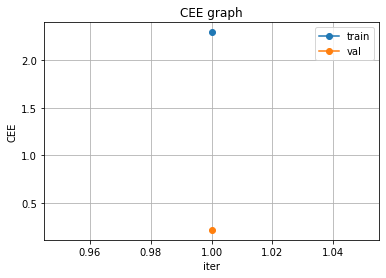

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


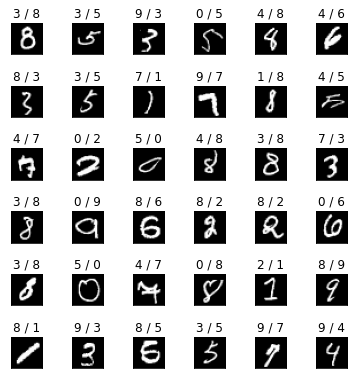

In [ ]:
cnn2d_1 = Scratch2dCNNClassifier(
                ch_out=[1],
                F_h=[4],
                F_w=[4],
                S_h=[1],
                S_w=[1],
                p=[2],
                q=[2],
                conv_sigma=0.01,
                flatten=Flatten(),
                hidden_layers=[400,200],
                hidden_activations=['relu', 'relu'],
                hidden_initializers=['he', 'he'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=20,
                epochs=1,
                lr=0.01,
                seed=0,
                verbose=False)

handler(cnn2d_1, X_train, y_train, X_val, y_val, 1)

In [ ]:
cnn2d_2 = Scratch2dCNNClassifier(
                ch_out=[1, 1],
                F_h=[5, 5],
                F_w=[5, 5],
                S_h=[1, 1],
                S_w=[1, 1],
                p=[2, 2],
                q=[2, 2],
                conv_sigma=0.01,
                flatten=Flatten(),
                hidden_layers=[120,84],
                hidden_activations=['relu', 'relu'],
                hidden_initializers=['he', 'he'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=20,
                epochs=1,
                lr=0.01,
                seed=0,
                verbose=False)

handler(cnn2d_2, X_train, y_train, X_val, y_val, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


KeyboardInterrupt: ignored